This notebook is based on exercise 2 of machine learning course by Andrew Ng on Coursera. Do read PDF detailing the excercise for this before proceeding.  Actual course material is in Octave, this is my effort to implememt same in Spark.
Required Data and PDF is available in the repository.

Import Required Libraries
-------------------

In [10]:
from pyspark.sql.types import DoubleType, StructField, StructType
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
import numpy as np
from pyspark.ml.classification import LogisticRegression

Read the Data
---------------------

In [4]:
#Create schema for reading data.
mat_schema = StructType()
mat_schema.add(StructField("marks1", DoubleType(), True))
mat_schema.add(StructField("marks2", DoubleType(), True))
mat_schema.add(StructField("decision", DoubleType(), True))

#Read the data into dataframe
data_df = spark.read.csv('file:///home/kamal/coursera/machinelearning/machine-learning-ex2/ex2/ex2data1.txt'
                              ,header=False,schema=mat_schema)

#The data needs to be stored as labeled data i.e in format -> [label, [features]]. Once done , this same data
#can be then used to train our Logistic Regression model.
data_df_new = spark.createDataFrame(data_df.rdd.map(lambda x: (x[-1],Vectors.dense(x[0:-1])))
                                            ,['label','features'])
data_df_new.first()

Row(label=0.0, features=DenseVector([34.6237, 78.0247]))

Train the model
----------------------

In [6]:
#Excercise one is with 400 iterations and without regularization.
lr = LogisticRegression(maxIter=400, regParam=0, tol=1e-09)
model = lr.fit(data_df_new)

In [7]:
#Check your calculated weights an intercept
print model.coefficients,model.intercept

[0.20623171351679329,0.20147160064465874] -25.1613335944


Check Model quality
-------------------

In [8]:
predictions = model.evaluate(data_df_new).predictions
correct_results = predictions.filter(predictions.label == predictions.prediction)
print "Got ",correct_results.count()," correct results out of ",predictions.count()

Got  89  correct results out of  100


In [11]:
#Check against given test data, result should be 0.776
test_df = sc.parallelize([
    Row(label=0, features=Vectors.dense(45.0, 85.0))]).toDF()
result = model.evaluate(test_df)
result.predictions.collect()[0][3][1]

0.7762906906911416

Plot the decision boundary
-------------------------------

In [12]:
#First convert the dataframes to individual numpy arrays i.e X1, X2 and Y.
#Also we draw a boundary where y = 0, so fixing the value of X1 (35 & 95) we can calculate value of X2
import numpy as np
x1 = data_df_new.rdd.map(lambda (x,y): y[0]).collect()
x2 = data_df_new.rdd.map(lambda (x,y): y[1]).collect()
y = data_df_new.rdd.map(lambda (x,y):x).collect()
x1_np = np.array(x1)
x2_np = np.array(x2)
x_data_boundary = [35, 95]

In [15]:
#All the code below is to separate out negative samples from positive samples for plotting and also calculates
#X2 using the model weights
xn = x1_np[[np.array(y) == 0]]
yn = x2_np[[np.array(y) == 0]]
xp = x1_np[[np.array(y) == 1]]
yp = x2_np[[np.array(y) == 1]]
y_data_boundary = [(-1/model.coefficients[1])*(model.intercept + model.coefficients[0]*35),
        (-1/model.coefficients[1])*(model.intercept + model.coefficients[0]*95)]

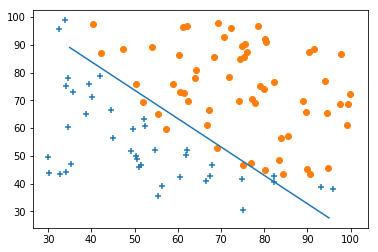

In [16]:
#All preparation done, plot the data.
%matplotlib inline
import matplotlib.pyplot as plt
plt.Figure()
plt.scatter(xn,yn,marker='+')
plt.scatter(xp,yp,marker='o')
plt.plot(x_data_boundary,y_data_boundary)
plt.show()

Exercise 2: Logistic Regression with Regularization
--------------------------------
### Read the data and plot it

In [17]:
#Same as in previous excercise, define the schema and read the data
mat2_schema = StructType()
mat2_schema.add(StructField("test1", DoubleType(), True))
mat2_schema.add(StructField("test2", DoubleType(), True))
mat2_schema.add(StructField("decision", DoubleType(), True))
data_df_ex2 = spark.read.csv('file:///home/kamal/coursera/machinelearning/machine-learning-ex2/ex2/ex2data2.txt'
                              ,header=False,schema=mat2_schema)

In [18]:
#Separate out negative and positive samples for plotting
data_df_ex2_accepted = data_df_ex2.filter(data_df_ex2.decision == 1)
data_df_ex2_rejected = data_df_ex2.filter(data_df_ex2.decision == 0)
xp = np.array(data_df_ex2_accepted.rdd.map(lambda x: x[0]).collect())
yp = np.array(data_df_ex2_accepted.rdd.map(lambda x: x[1]).collect())
xn = np.array(data_df_ex2_rejected.rdd.map(lambda x: x[0]).collect())
yn = np.array(data_df_ex2_rejected.rdd.map(lambda x: x[1]).collect())

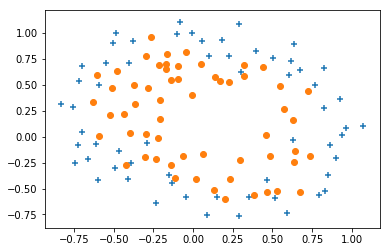

In [19]:
#Plot the data
plt.Figure()
plt.scatter(xn,yn,marker='+')
plt.scatter(xp,yp,marker='o')
plt.show()

Create extra features
-----------------------------
In this excercise, extra features are added using power function - X^n.  Thsi gives us total of 27 features excluding intercept. Read the material in PDF for more clarity. 

In [20]:
#Here x is two element array 
def mapFeature(x):
    mappedfeature = []
    for i in [1,2,3,4,5,6]:
        for j in range(i+1):
            mappedfeature.append(x[0]**(i-j)*x[1]**j)
    return mappedfeature            

In [21]:
#Now we use mapfeature function and create labeled dataframe to use for training 
data_df_new_ex2 = spark.createDataFrame(data_df_ex2.rdd.map(lambda x: (x[-1],Vectors.dense(mapFeature(x[0:-1]))))
                                            ,['label','features'])
data_df_new_ex2.first()

Row(label=1.0, features=DenseVector([0.0513, 0.6996, 0.0026, 0.0359, 0.4894, 0.0001, 0.0018, 0.0251, 0.3424, 0.0, 0.0001, 0.0013, 0.0176, 0.2395, 0.0, 0.0, 0.0001, 0.0009, 0.0123, 0.1675, 0.0, 0.0, 0.0, 0.0, 0.0006, 0.0086, 0.1172]))

In [79]:
#In octave implementation lambda = 1 will translate to  1/m in spark. So Lambda 1 is 1/118 over here.
models = {}
for regp in [0.084,0.0084,0.000084,0.0000084]:
    models[str(regp)] = LogisticRegression(maxIter=400, regParam=regp).fit(data_df_new_ex2)

Check Model Quality
------------------------------

In [80]:
for regp, model_ex2 in models.iteritems():
    predictions_ex2 = model_ex2.evaluate(data_df_new_ex2).predictions
    correct_results = predictions_ex2.filter(predictions_ex2.label == predictions_ex2.prediction)
    print "For Regularization factor ", regp, " Got ",correct_results.count()," correct results out of ",predictions_ex2.count()

For Regularization factor  8.4e-06  Got  103  correct results out of  118
For Regularization factor  8.4e-05  Got  102  correct results out of  118
For Regularization factor  0.084  Got  99  correct results out of  118
For Regularization factor  0.0084  Got  98  correct results out of  118


Plot the decision Boundary
------------------------------------

In [81]:
u = np.linspace(-1, 1.5, 50);
v = np.linspace(-1, 1.5, 50);
def get_zmap(theta_np,intercept):
    z = np.zeros((len(u), len(v)));
    for i in range(len(u)):
        for j in range(len(v)):
            z[i,j] = np.matmul(mapFeature([u[i],v[j]]),np.transpose(theta_np))  + intercept
    z = np.transpose(z)
    return z

In [82]:
#The code here comes directly from octave implementation. But in short, it creates a mesh of X and Y data points,
#then calculates corresponding Z values. 
theta_np  = np.array(models[str(0.084)].coefficients)
intercept = models[str(0.084)].intercept
z = get_zmap(theta_np,intercept)
theta_np  = np.array(models[str(0.0084)].coefficients)
intercept = models[str(0.0084)].intercept
z1 = get_zmap(theta_np,intercept)
theta_np  = np.array(models[str(0.000084)].coefficients)
intercept = models[str(0.000084)].intercept
z2 = get_zmap(theta_np,intercept)
theta_np  = np.array(models[str(0.0000084)].coefficients)
intercept = models[str(0.0000084)].intercept
z3 = get_zmap(theta_np,intercept)

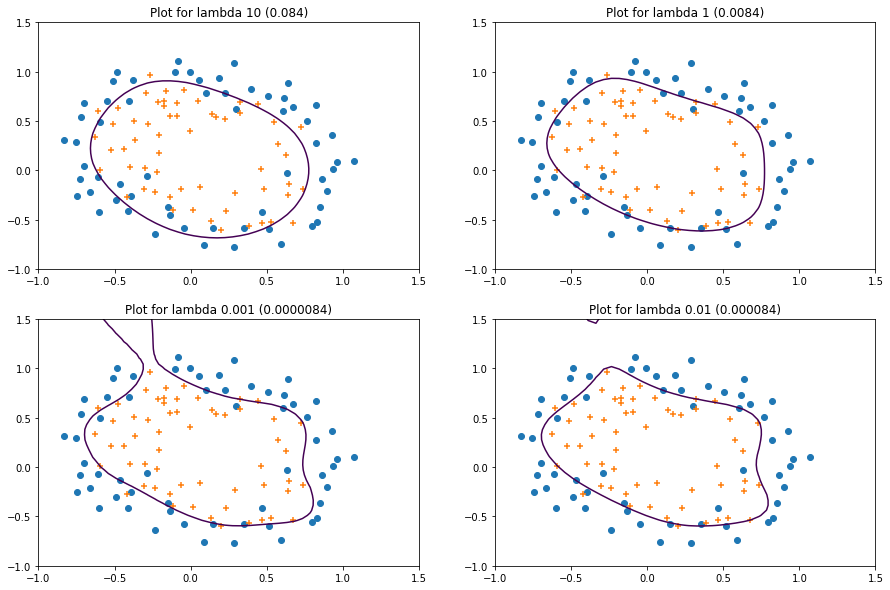

In [83]:
plt.Figure()
plt.subplot(221)
plt.title("Plot for lambda 10 (0.084)")
plt.scatter(xn,yn,marker='o')
plt.scatter(xp,yp,marker='+')
plt.contour(u, v, z,levels=[0])
plt.subplot(222)
plt.title("Plot for lambda 1 (0.0084)")
plt.scatter(xn,yn,marker='o')
plt.scatter(xp,yp,marker='+')
plt.contour(u, v, z1,levels=[0])
plt.subplot(223)
plt.title("Plot for lambda 0.001 (0.0000084)")
plt.scatter(xn,yn,marker='o')
plt.scatter(xp,yp,marker='+')
plt.contour(u, v, z3,levels=[0])
plt.subplot(224)
plt.title("Plot for lambda 0.01 (0.000084)")
plt.scatter(xn,yn,marker='o')
plt.scatter(xp,yp,marker='+')
plt.contour(u, v, z2,levels=[0])
plt.rcParams["figure.figsize"] = (15,10)